In [22]:
import numpy as np
import matplotlib.pyplot as plt 

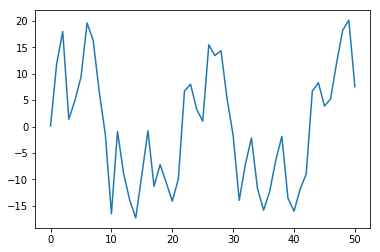

In [23]:
np.random.seed(0)
T = 50 # number of steps
Q = 10 # process noise
R = 1 # measurement noise

# ground truth and measurements
x = np.zeros(T+1)
y = np.zeros(T+1)
x[0] = 0.1
y[0] = 0.05*x[0]**2 + np.random.normal(0, np.sqrt(R))
for k in range(0,T):
    x[k + 1] = 0.5*x[k] + 25*x[k]/(1+x[k]**2) + 8*np.cos(1.2*k) + np.random.normal(0, np.sqrt(Q))
    y[k + 1] = 0.05*x[k+1]**2 + np.random.normal(0, np.sqrt(R))

plt.plot(range(T+1), x)

In [24]:
# functions 

# pass sigma points forward
def fx(sigmas, step):
    sigmas_f = np.zeros(len(sigmas))
    for i,s in enumerate(sigmas):
        sigmas_f[i] = 0.5*s + 25*s/(1+s**2) + 8*np.cos(1.2*step) + np.random.normal(0, np.sqrt(Q))
    return sigmas_f

def hx(sigmas_f):
    sigmas_m = np.zeros(len(sigmas))
    for i,s in enumerate(sigmas_f):
        sigmas_m[i] = 0.05*s**2 + np.random.normal(0, np.sqrt(R))
    return sigmas_m

In [64]:
from filterpy.kalman import unscented_transform, MerweScaledSigmaPoints

# initialize 
m0 = 0
p0 = 2
P = p0
x_hat = y[0]
points = MerweScaledSigmaPoints(n=1, alpha=1., beta=1., kappa=2.)
x_hats = []
x_hats.append(x_hat)
Ps = []
Ps.append(P)

# loop
for t in range(0,T):
    # predict step
    sigmas = points.sigma_points(x_hat, P)
    sigmas_f = fx(sigmas, t)
    x_p = 0
    p_p = 0
    for s, wm in zip(sigmas_f, points.Wm):
        x_p += wm*s
    for s, wc in zip(sigmas_f, points.Wc):
        p_p += wc*(s-x_p)**2
    p_p += Q
    
    # update step
    sigmas_m = hx(sigmas_f)
    x_m = 0
    p_m = 0
    for s, wm in zip(sigmas_m, points.Wm):
        x_m += wm*s
    for s, wc in zip(sigmas_m, points.Wc):
        p_m += wc*(s-x_m)**2
    p_m += R
    
    residual = y[t+1] - x_m
    Pxz = 0
    for sf, sm, wc in zip(sigmas_f, sigmas_m, points.Wc):
        Pxz += wc*(sf - x_p)*(sm - x_m)
    
    K = Pxz / p_m
    x_hat = x_m + K*residual
    P = p_p - K*p_m*K
    x_hats.append(x_hat)
    Ps.append(P)

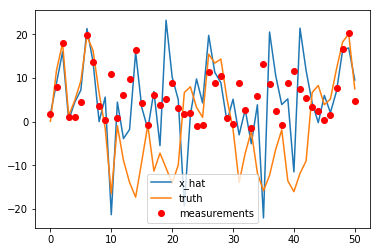

In [65]:
plt.figure(1)
plt.plot(range(T+1), x_hats, label='x_hat')
plt.plot(range(T+1), x, label='truth')
plt.plot(range(T+1), y, 'ro', label='measurements')
plt.legend()
plt.show()

In [53]:
np.save('estimates/ukf_x.npy', x_hats)